# Modeling Credit Risk with Lending Club data

### Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

Notes:
Address is a key feature. Try to get it. Zip_code from address wil dramatically improve results.
And use ohe for more cat features.

### Business Problem

### Objective

### Summary of Results

## 2. Data import

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [35]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [36]:
time0 = time.time()

with open('../input/lc-sample850k/LCLoans_sample850k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries']

df = df[features_tokeep]

recoveries = df[['id', 'recoveries', 'loan_amnt', 'int_rate']]

df.drop(columns = ['recoveries'], inplace=True)
df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 67)

1.7689831256866455

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,Charged Off,12000.0,12000.0,11925.0,60.0,19.99,317.859985,2016-03-01,debt_consolidation,Debt consolidation,w,Individual,E,E1,689.0,Analyst,< 1 year,RENT,40000.0,853xx,AZ,6.650000,Source Verified,3.0,NaN,NaN,NaN,NaN,NaN,5.0,Oct-2006,0.0,0.0,0.0,15.0,7.0,0.0,24.0,3663.0,54945.0,5945.0,50.4,5855.0,3.0,4.0,4.0,11800.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,54945.0,0.0,0.0,0.000000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2016.0
1,Fully Paid,12000.0,12000.0,12000.0,60.0,21.18,325.859985,2016-02-01,major_purchase,Major purchase,w,Individual,E,E3,679.0,Product manager,5 years,MORTGAGE,100000.0,786xx,TX,24.610001,Not Verified,7.0,NaN,NaN,82.0,NaN,NaN,3.0,Apr-1999,2.0,4.0,7.0,20.0,15.0,4.0,39.0,13306.0,226209.0,31216.0,57.1,20645.0,11.0,9.0,16.0,54700.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,78974.0,150.0,0.0,44.400002,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2016.0
2,Charged Off,20000.0,20000.0,20000.0,60.0,15.61,482.230011,2014-08-01,debt_consolidation,Debt consolidation,w,Individual,D,D1,694.0,Web Developer,1 year,RENT,85000.0,194xx,PA,20.360001,Source Verified,3.0,14.0,14.0,36.0,27.0,27.0,3.0,Sep-2001,0.0,NaN,NaN,14.0,4.0,0.0,29.0,8247.0,115451.0,4328.0,66.6,1672.0,10.0,3.0,4.0,6500.0,1.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,115451.0,0.0,2.0,66.699997,93.099998,NaN,NaN,1.0,0.0,0.0,1.0,2014.0
3,Current,4000.0,4000.0,4000.0,36.0,12.40,133.630005,2019-10-01,home_improvement,Home improvement,w,Individual,B,B4,674.0,Customer Service supervisor,10+ years,RENT,65000.0,900xx,CA,16.490000,Not Verified,14.0,17.0,NaN,NaN,17.0,17.0,0.0,May-2012,1.0,2.0,1.0,8.0,2.0,0.0,12.0,3911.0,31291.0,7979.0,51.1,6168.0,33.0,4.0,6.0,15600.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,31291.0,0.0,0.0,25.000000,91.699997,0.0,0.0,0.0,0.0,0.0,0.0,2019.0
4,Charged Off,12000.0,12000.0,12000.0,36.0,6.49,367.739990,2016-02-01,debt_consolidation,Debt consolidation,w,Individual,A,A2,804.0,NaN,NaN,OWN,55500.0,956xx,CA,5.450000,Not Verified,16.0,NaN,NaN,NaN,NaN,NaN,0.0,Aug-1984,0.0,6.0,2.0,17.0,3.0,5.0,33.0,25111.0,401783.0,9157.0,11.3,49056.0,23.0,8.0,15.0,80800.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,9157.0,0.0,0.0,14.300000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2016.0


## 3. Data preprocessing

In [37]:
### feature description:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])

73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [38]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [39]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,Charged Off,12000.0,12000.0,11925.0,60.0,19.99,317.859985,2016-03-01,debt_consolidation,Debt consolidation,w,Individual,E,E1,689.0,Analyst,< 1 year,RENT,40000.0,853xx,AZ,6.650000,Source Verified,3.0,NaN,NaN,NaN,NaN,NaN,5.0,2006-10-01,0.0,0.0,0.0,15.0,7.0,0.0,24.0,3663.0,54945.0,5945.0,50.4,5855.0,3.0,4.0,4.0,11800.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,54945.0,0.0,0.0,0.000000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2016.0,3,2016,9.415662,0.000000
1,Fully Paid,12000.0,12000.0,12000.0,60.0,21.18,325.859985,2016-02-01,major_purchase,Major purchase,w,Individual,E,E3,679.0,Product manager,5 years,MORTGAGE,100000.0,786xx,TX,24.610001,Not Verified,7.0,NaN,NaN,82.0,NaN,NaN,3.0,1999-04-01,2.0,4.0,7.0,20.0,15.0,4.0,39.0,13306.0,226209.0,31216.0,57.1,20645.0,11.0,9.0,16.0,54700.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,78974.0,150.0,0.0,44.400002,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2016.0,2,2016,16.838128,0.059389
2,Charged Off,20000.0,20000.0,20000.0,60.0,15.61,482.230011,2014-08-01,debt_consolidation,Debt consolidation,w,Individual,D,D1,694.0,Web Developer,1 year,RENT,85000.0,194xx,PA,20.360001,Source Verified,3.0,14.0,14.0,36.0,27.0,27.0,3.0,2001-09-01,0.0,NaN,NaN,14.0,4.0,0.0,29.0,8247.0,115451.0,4328.0,66.6,1672.0,10.0,3.0,4.0,6500.0,1.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,115451.0,0.0,2.0,66.699997,93.099998,NaN,NaN,1.0,0.0,0.0,1.0,2014.0,8,2014,12.914707,0.154862
3,Current,4000.0,4000.0,4000.0,36.0,12.40,133.630005,2019-10-01,home_improvement,Home improvement,w,Individual,B,B4,674.0,Customer Service supervisor,10+ years,RENT,65000.0,900xx,CA,16.490000,Not Verified,14.0,17.0,NaN,NaN,17.0,17.0,0.0,2012-05-01,1.0,2.0,1.0,8.0,2.0,0.0,12.0,3911.0,31291.0,7979.0,51.1,6168.0,33.0,4.0,6.0,15600.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,31291.0,0.0,0.0,25.000000,91.699997,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,10,2019,7.416990,0.000000
4,Charged Off,12000.0,12000.0,12000.0,36.0,6.49,367.739990,2016-02-01,debt_consolidation,Debt consolidation,w,Individual,A,A2,804.0,NaN,NaN,OWN,55500.0,956xx,CA,5.450000,Not Verified,16.0,NaN,NaN,NaN,NaN,NaN,0.0,1984-08-01,0.0,6.0,2.0,17.0,3.0,5.0,33.0,25111.0,401783.0,9157.0,11.3,49056.0,23.0,8.0,15.0,80800.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,9157.0,0.0,0.0,14.300000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,2,2016,31.502358,0.000000


In [40]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             98984
Current                                                72740
Charged Off                                            25498
Late (31-120 days)                                      1171
In Grace Period                                          716
Late (16-30 days)                                        201
Does not meet the credit policy. Status:Fully Paid       152
Issued                                                   125
Does not meet the credit policy. Status:Charged Off       46
Default                                                   34
Name: loan_status, dtype: int64

(124516, 72)

Fully Paid                                             98984
Charged Off                                            25498
Default                                                   34
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

loan_status                       124516
loan_amnt                         124516
funded_amnt                       124516
funded_amnt_inv                   124516
term                              124516
int_rate                          124516
installment                       124516
issue_d                           124516
purpose                           124516
title                             123073
initial_list_status               124516
application_type                  124516
grade                             124516
sub_grade                         124516
fico_range_high                   124516
emp_title                         115934
emp_length                        116877
home_ownership                    124516
annual_inc                        124516
zip_code                          124516
addr_state                        124516
dti                               124453
verification_status               124516
mo_sin_rcnt_tl                    120007
mths_since_last_

55.17969036102295

### Feature Preprocessing

In [41]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    41191
2.0     11332
0.0     10257
3.0      9904
1.0      8315
5.0      7707
4.0      7460
6.0      5769
7.0      5239
8.0      5199
9.0      4504
Name: emp_length, dtype: int64

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,12000.0,12000.0,11925.0,60.0,19.99,317.859985,debt_consolidation,Debt consolidation,w,Individual,E,E1,689.0,Analyst,0.0,RENT,40000.0,853,AZ,6.650000,Source Verified,3.0,NaN,NaN,NaN,NaN,NaN,5.0,0.0,0.0,0.0,15.0,7.0,0.0,24.0,3663.0,54945.0,5945.0,50.4,5855.0,3.0,4.0,4.0,11800.0,0.0,0.0,0.0,0.0,0.0,54945.0,0.0,0.0,0.000000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2016.0,3,2016,9.415662,0.000000,1.0,0.300000,0.095358,0,0.148625,0.091575,1.373625,1.373625,0.295000,0,0.625000,0
1,12000.0,12000.0,12000.0,60.0,21.18,325.859985,major_purchase,Major purchase,w,Individual,E,E3,679.0,Product manager,5.0,MORTGAGE,100000.0,786,TX,24.610001,Not Verified,7.0,NaN,NaN,82.0,NaN,NaN,3.0,2.0,4.0,7.0,20.0,15.0,4.0,39.0,13306.0,226209.0,31216.0,57.1,20645.0,11.0,9.0,16.0,54700.0,0.0,0.0,0.0,1.0,1.0,78974.0,150.0,0.0,44.400002,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2016.0,2,2016,16.838128,0.059389,0.0,0.120000,0.039103,0,0.312160,0.133060,2.262090,0.789740,0.547000,0,0.512821,1
2,20000.0,20000.0,20000.0,60.0,15.61,482.230011,debt_consolidation,Debt consolidation,w,Individual,D,D1,694.0,Web Developer,1.0,RENT,85000.0,194,PA,20.360001,Source Verified,3.0,14.0,14.0,36.0,27.0,27.0,3.0,0.0,NaN,NaN,14.0,4.0,0.0,29.0,8247.0,115451.0,4328.0,66.6,1672.0,10.0,3.0,4.0,6500.0,1.0,0.0,0.0,2.0,0.0,115451.0,0.0,2.0,66.699997,93.099998,NaN,NaN,1.0,0.0,0.0,1.0,2014.0,8,2014,12.914707,0.154862,1.0,0.235294,0.068080,0,0.050918,0.097024,1.358247,1.358247,0.076471,0,0.482759,0
4,12000.0,12000.0,12000.0,36.0,6.49,367.739990,debt_consolidation,Debt consolidation,w,Individual,A,A2,804.0,NaN,NaN,OWN,55500.0,956,CA,5.450000,Not Verified,16.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.0,2.0,17.0,3.0,5.0,33.0,25111.0,401783.0,9157.0,11.3,49056.0,23.0,8.0,15.0,80800.0,0.0,0.0,0.0,0.0,0.0,9157.0,0.0,0.0,14.300000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,2,2016,31.502358,0.000000,1.0,0.216216,0.079511,0,0.164991,0.452450,7.239333,0.164991,1.455856,0,0.515152,0
7,16000.0,16000.0,16000.0,60.0,10.99,347.799988,debt_consolidation,Debt consolidation,w,Individual,B,B4,724.0,Warehouseman,10.0,RENT,55000.0,906,CA,12.070000,Not Verified,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,14.0,1.0,4.0,26.0,25215.0,252151.0,15825.0,49.6,5547.0,4.0,8.0,13.0,31900.0,0.0,0.0,0.0,0.0,0.0,15825.0,0.0,0.0,33.299999,96.199997,NaN,NaN,0.0,0.0,0.0,1.0,2015.0,4,2015,38.998747,0.000000,0.0,0.290909,0.075884,0,0.287727,0.458455,4.584564,0.287727,0.580000,0,0.538462,0


In [42]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



loan_amnt                         124516
funded_amnt                       124516
funded_amnt_inv                   124516
term                              124516
int_rate                          124516
installment                       124516
purpose                           124516
title                             123073
initial_list_status               124516
application_type                  124516
grade                             124516
sub_grade                         124516
fico_range_high                   124516
emp_title                         115934
emp_length                        116877
home_ownership                    124516
annual_inc                        124516
zip_code                          124516
addr_state                        124516
dti                               124453
verification_status               124516
mo_sin_rcnt_tl                    124516
mths_since_last_delinq            124516
mths_since_last_major_derog       124516
mths_since_last_

In [43]:
df.mo_sin_rcnt_tl.describe()

count    124516.000000
mean         12.172934
std          22.667328
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         272.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [44]:
df.verification_status.value_counts()

Source Verified    49113
Not Verified       40085
Verified           35318
Name: verification_status, dtype: int64

In [45]:
df.target.mean()

0.20504995341964086

In [46]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [47]:
df.application_type.value_counts()

Individual    119963
Joint App       4553
Name: application_type, dtype: int64

### EDA

In [48]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,124516.000000,124516.000000,124516.000000
mean,14497.807617,14491.391602,14474.323242
std,8990.283203,8987.115234,8987.383789
min,500.000000,500.000000,0.000000
25%,7500.000000,7500.000000,7500.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95460
60.0    29056
Name: term, dtype: int64

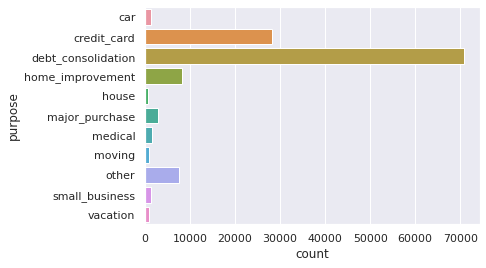

<AxesSubplot:xlabel='count', ylabel='emp_length'>

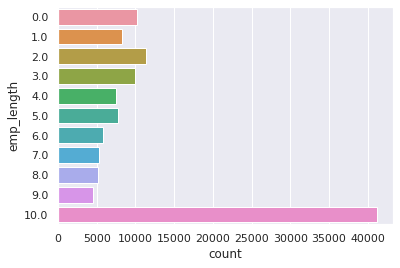

In [49]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [50]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [51]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    25532.000000
mean         0.345566
std          0.945295
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: delinq_2yrs, dtype: float64

count    98984.000000
mean         0.303342
std          0.854698
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: delinq_2yrs, dtype: float64

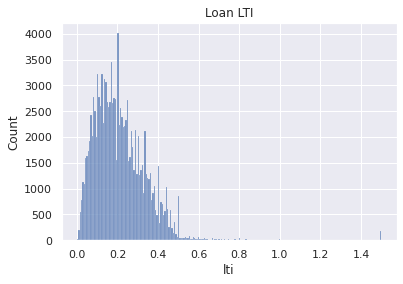

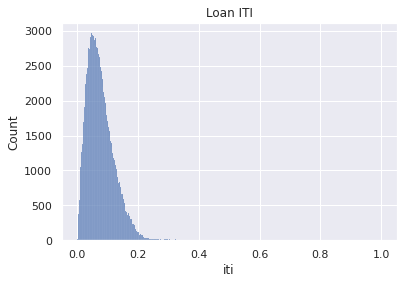

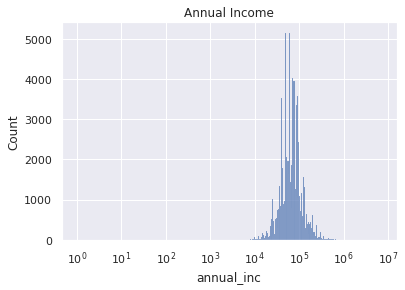

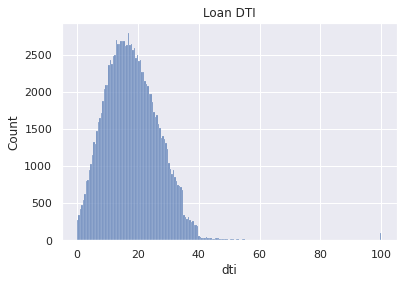

In [52]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [53]:
df.dti.describe()

count    124453.000000
mean         18.275734
std           9.241857
min           0.000000
25%          11.700000
50%          17.520000
75%          24.049999
max         100.000000
Name: dti, dtype: float64

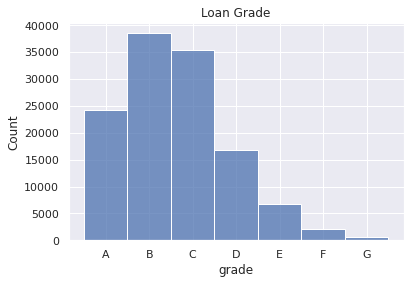

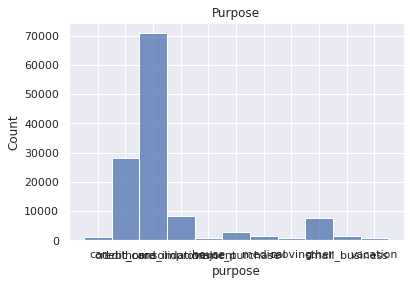

In [54]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()
sns.histplot(x='purpose', data=df).set(title='Purpose')
plt.show()

In [55]:
df.purpose.value_counts()

debt_consolidation    70801
credit_card           28235
home_improvement       8278
other                  7609
major_purchase         2880
medical                1587
small_business         1357
car                    1272
vacation                883
moving                  869
house                   745
Name: purpose, dtype: int64

### EDA with target

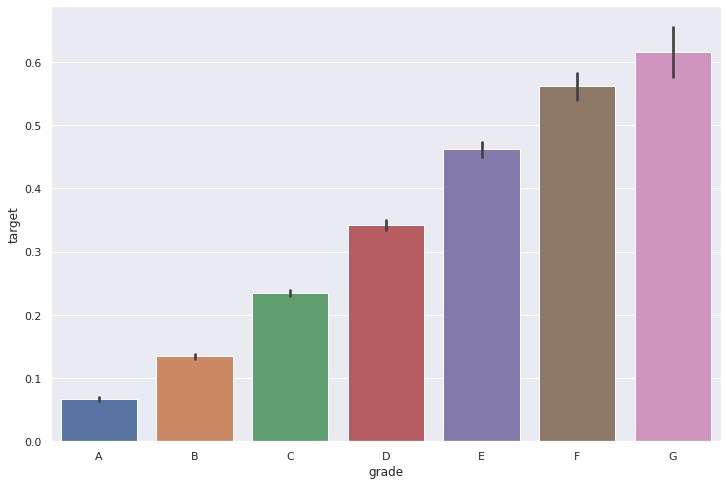

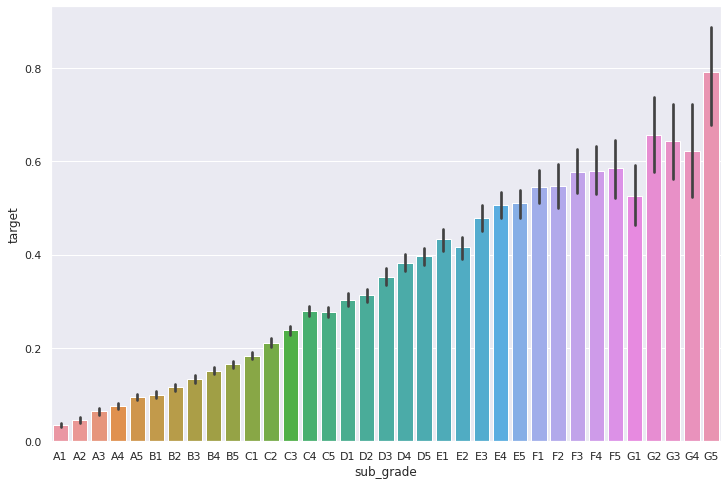

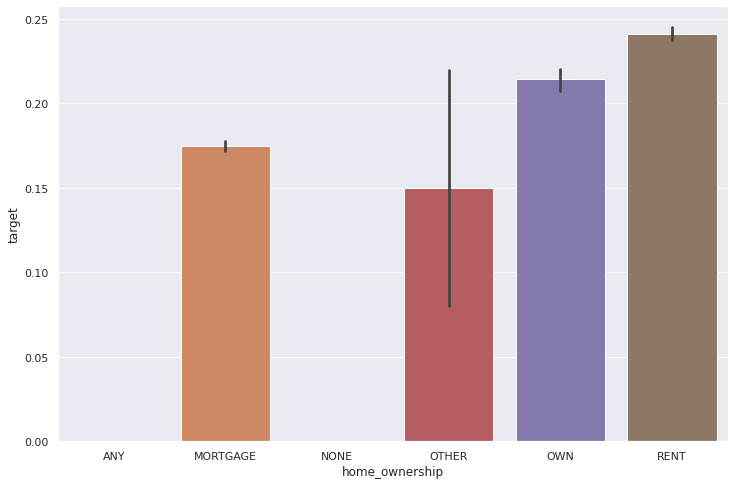

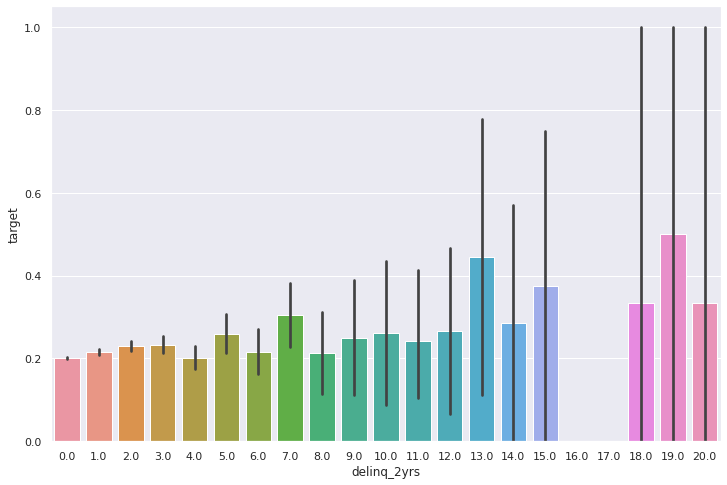

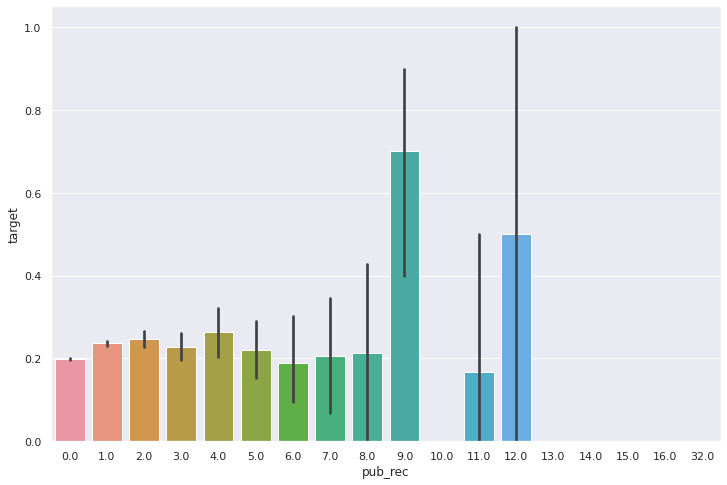

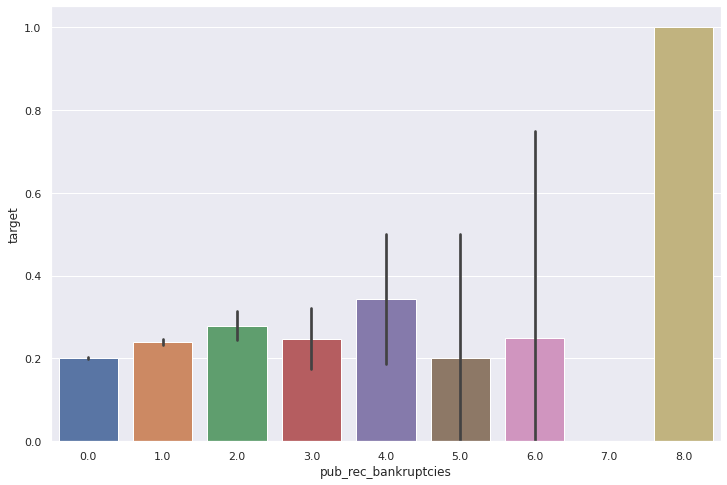

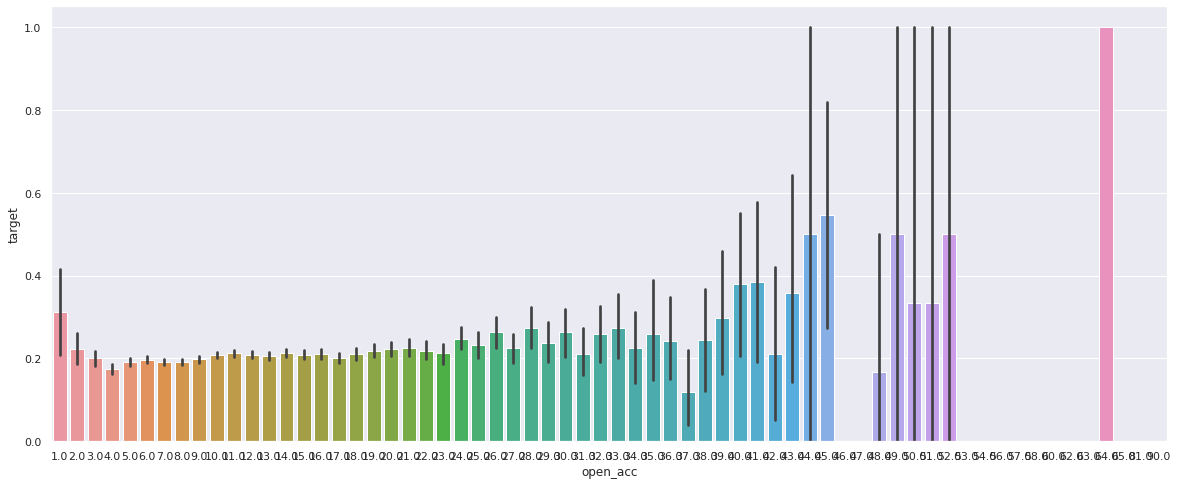

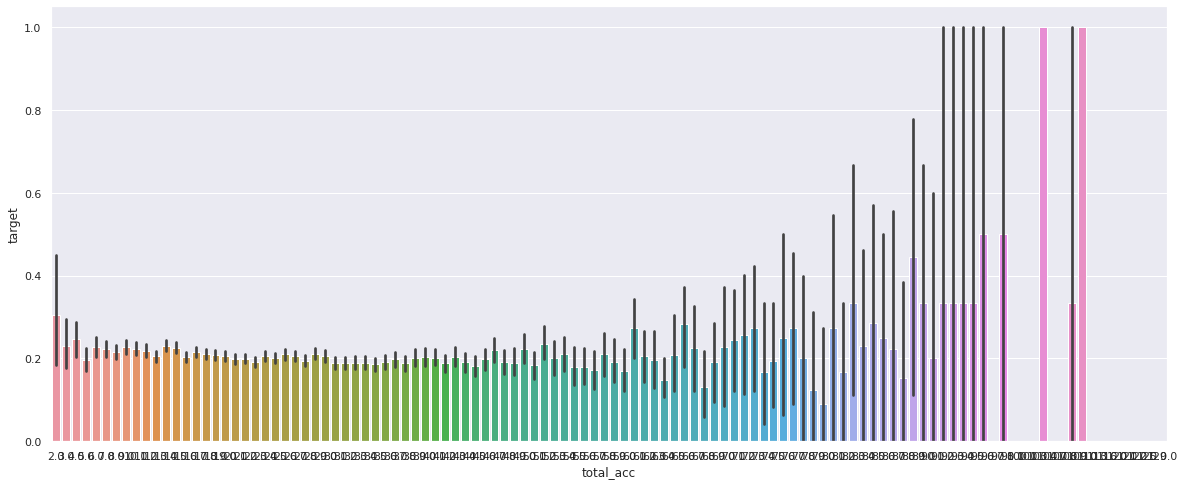

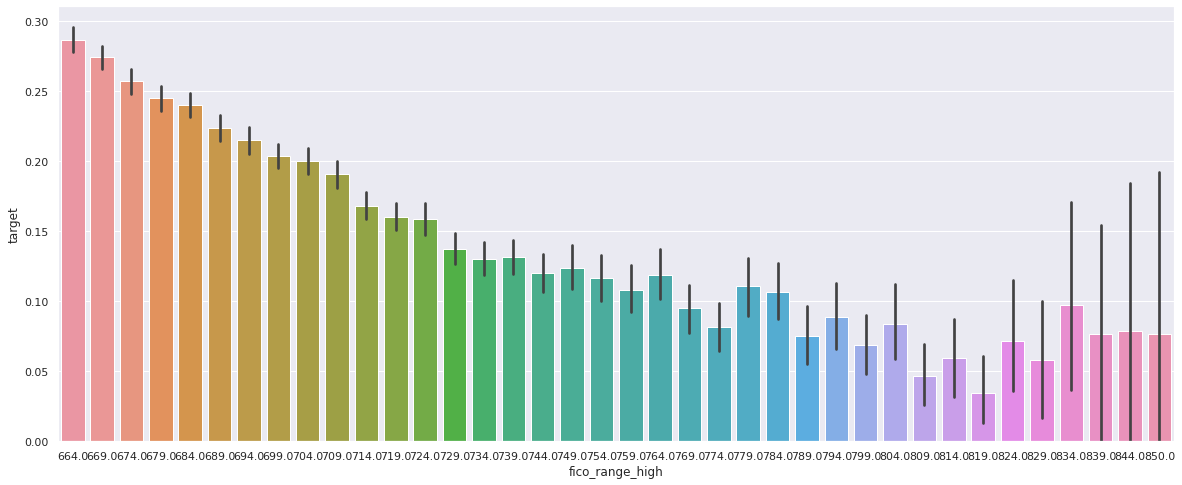

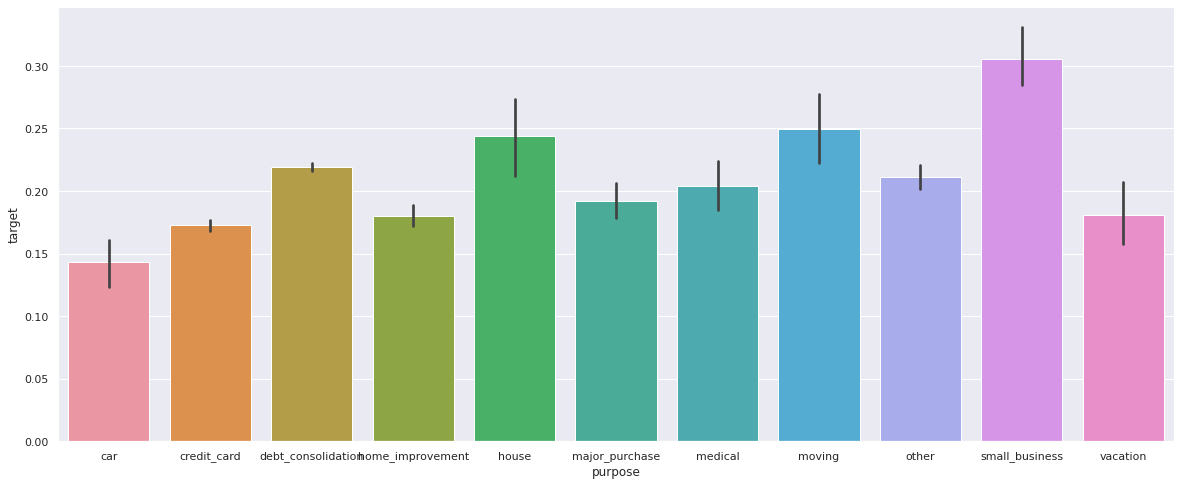

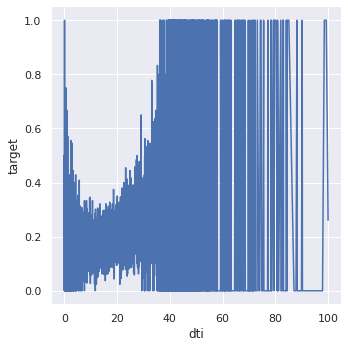

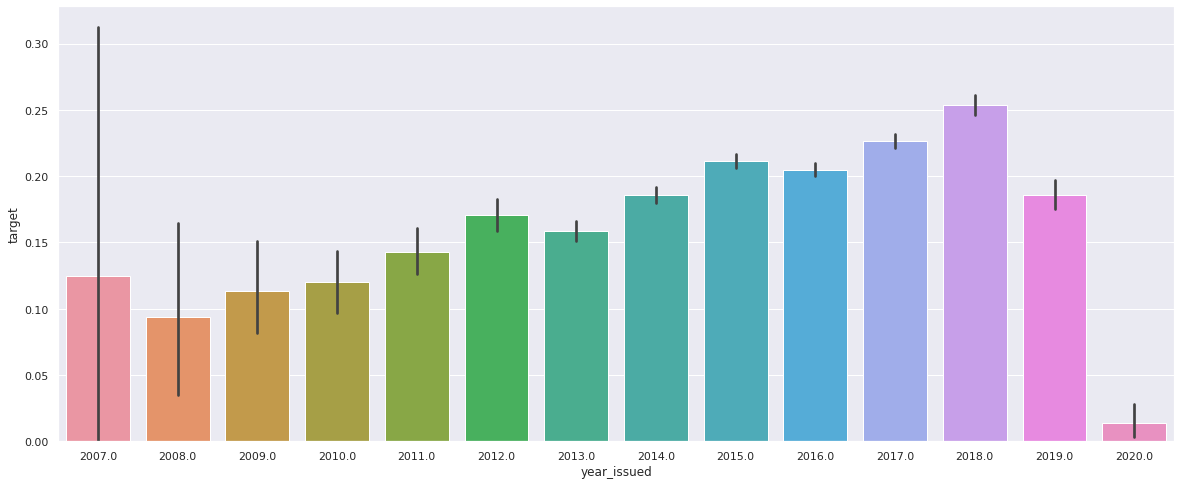

In [56]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

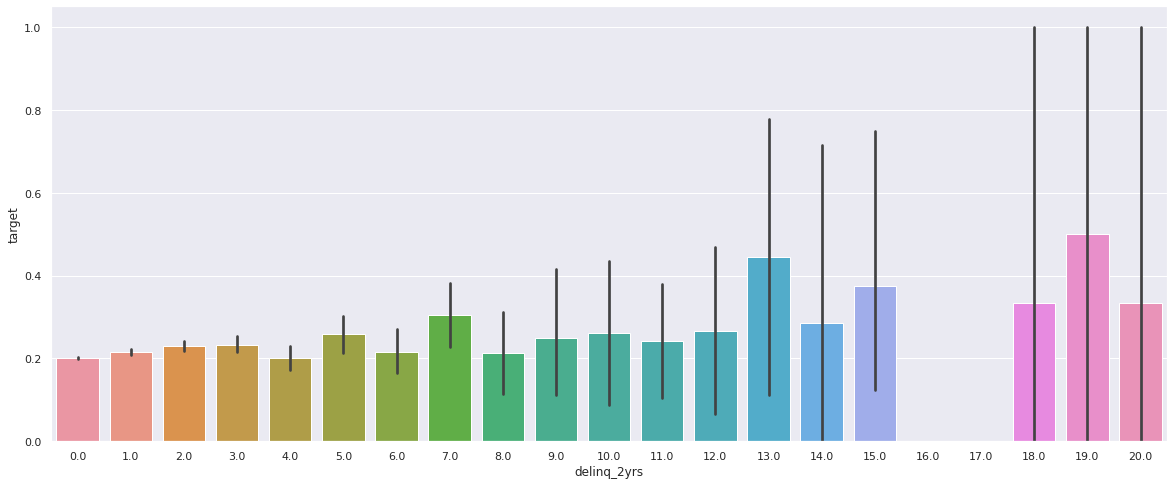

In [57]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

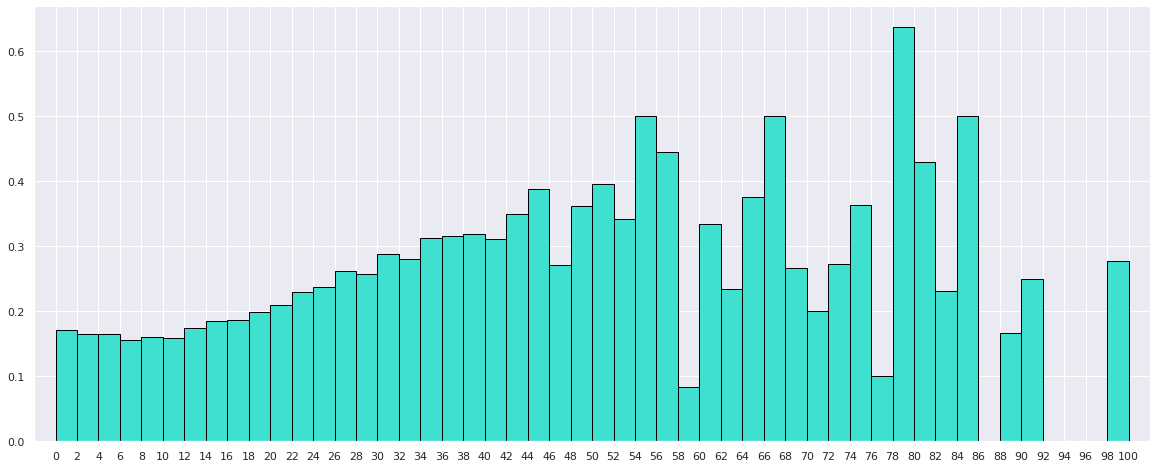

In [58]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### Train-test split, missing values

In [59]:
display(df.count())

loan_amnt                         124516
funded_amnt                       124516
funded_amnt_inv                   124516
term                              124516
int_rate                          124516
installment                       124516
purpose                           124516
title                             123073
initial_list_status               124516
application_type                  124516
grade                             124516
sub_grade                         124516
fico_range_high                   124516
emp_title                         115934
emp_length                        116877
home_ownership                    124516
annual_inc                        124516
zip_code                          124516
addr_state                        124516
dti                               124453
verification_status               124516
mo_sin_rcnt_tl                    124516
mths_since_last_delinq            124516
mths_since_last_major_derog       124516
mths_since_last_

In [60]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.25
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(93387, 77)

(31129, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,12000.0,12000.0,11925.0,60.0,19.99,317.859985,debt_consolidation,Debt consolidation,w,Individual,E,E1,689.0,Analyst,0.0,RENT,40000.0,853,AZ,6.650000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,0.0,0.0,15.0,7.0,0.0,24.0,3663.0,54945.0,5945.0,50.4,5855.0,3.0,4.0,4.0,11800.0,0.0,0.0,0.0,0.0,0.0,54945.0,0.0,0.0,0.000000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2016.0,3,2016,9.415662,0.000000,1.0,0.300000,0.095358,0,0.148625,0.091575,1.373625,1.373625,0.295000,0,0.625000,0
1,20000.0,20000.0,20000.0,60.0,15.61,482.230011,debt_consolidation,Debt consolidation,w,Individual,D,D1,694.0,Web Developer,1.0,RENT,85000.0,194,PA,20.360001,Source Verified,3.0,14.0,14.0,36.0,27.0,27.0,3.0,0.0,0.0,0.0,14.0,4.0,0.0,29.0,8247.0,115451.0,4328.0,66.6,1672.0,10.0,3.0,4.0,6500.0,1.0,0.0,0.0,2.0,0.0,115451.0,0.0,2.0,66.699997,93.099998,0.0,0.0,1.0,0.0,0.0,1.0,2014.0,8,2014,12.914707,0.154862,1.0,0.235294,0.068080,0,0.050918,0.097024,1.358247,1.358247,0.076471,0,0.482759,0
2,16000.0,16000.0,16000.0,60.0,10.99,347.799988,debt_consolidation,Debt consolidation,w,Individual,B,B4,724.0,Warehouseman,10.0,RENT,55000.0,906,CA,12.070000,Not Verified,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,1.0,0.0,0.0,14.0,1.0,4.0,26.0,25215.0,252151.0,15825.0,49.6,5547.0,4.0,8.0,13.0,31900.0,0.0,0.0,0.0,0.0,0.0,15825.0,0.0,0.0,33.299999,96.199997,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,4,2015,38.998747,0.000000,0.0,0.290909,0.075884,0,0.287727,0.458455,4.584564,0.287727,0.580000,0,0.538462,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,13325.0,13325.0,13325.0,60.0,22.99,375.570007,debt_consolidation,Debt consolidation,w,Individual,F,F1,689.0,Teacher,3.0,RENT,47000.0,381,TN,33.630001,Verified,2.0,14.0,14.0,1200.0,1200.0,1200.0,4.0,2.0,0.0,0.0,12.0,5.0,0.0,19.0,3736.0,44833.0,0.0,0.0,13300.0,13.0,0.0,3.0,13300.0,1.0,0.0,0.0,0.0,0.0,44833.0,0.0,0.0,0.0,94.400002,0.0,0.0,1.0,0.0,0.0,1.0,2015.0,5,2015,5.579854,0.000000,1.0,0.283511,0.095890,0,0.000000,0.079489,0.953894,0.953894,0.282979,0,0.631579,0
1,8000.0,8000.0,8000.0,36.0,12.49,267.600006,debt_consolidation,Debt consolidation,f,Individual,B,B5,699.0,sales,1.0,MORTGAGE,55000.0,146,NY,8.160000,Not Verified,6.0,1200.0,1200.0,89.0,1200.0,1200.0,2.0,1.0,0.0,0.0,9.0,4.0,0.0,13.0,1192.0,10725.0,5535.0,31.3,6687.0,6.0,5.0,8.0,17700.0,0.0,0.0,0.0,1.0,1.0,10725.0,0.0,0.0,50.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,6,2014,10.165849,0.098369,0.0,0.145455,0.058385,0,0.100636,0.021673,0.195000,0.195000,0.321818,0,0.692308,1
2,25000.0,25000.0,25000.0,60.0,19.47,655.000000,credit_card,Credit card refinancing,f,Individual,D,D5,689.0,Call Taker,0.0,MORTGAGE,115000.0,346,FL,14.870000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,4.0,2.0,0.0,0.0,11.0,9.0,3.0,20.0,26297.0,289264.0,25558.0,86.1,1559.0,3.0,6.0,7.0,29700.0,0.0,0.0,0.0,0.0,0.0,51851.0,0.0,0.0,75.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,3,2014,16.999665,0.000000,0.0,0.217391,0.068348,0,0.222243,0.228670,2.515339,0.450878,0.258261,0,0.550000,0


loan_amnt                         93387
funded_amnt                       93387
funded_amnt_inv                   93387
term                              93387
int_rate                          93387
installment                       93387
purpose                           93387
title                             93387
initial_list_status               93387
application_type                  93387
grade                             93387
sub_grade                         93387
fico_range_high                   93387
emp_title                         93387
emp_length                        93387
home_ownership                    93387
annual_inc                        93387
zip_code                          93387
addr_state                        93387
dti                               93387
verification_status               93387
mo_sin_rcnt_tl                    93387
mths_since_last_delinq            93387
mths_since_last_major_derog       93387
mths_since_last_record            93387


loan_amnt                         31129
funded_amnt                       31129
funded_amnt_inv                   31129
term                              31129
int_rate                          31129
installment                       31129
purpose                           31129
title                             31129
initial_list_status               31129
application_type                  31129
grade                             31129
sub_grade                         31129
fico_range_high                   31129
emp_title                         31129
emp_length                        31129
home_ownership                    31129
annual_inc                        31129
zip_code                          31129
addr_state                        31129
dti                               31129
verification_status               31129
mo_sin_rcnt_tl                    31129
mths_since_last_delinq            31129
mths_since_last_major_derog       31129
mths_since_last_record            31129


### Categorical features encoding

In [61]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

47.2739200592041

3.6361923217773438

(93387, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,12000.0,12000.0,11925.0,60.0,19.99,317.859985,w,Individual,689.0,0.0,40000.0,6.650000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,0.0,0.0,15.0,7.0,0.0,24.0,3663.0,54945.0,5945.0,50.4,5855.0,3.0,4.0,4.0,11800.0,0.0,0.0,0.0,0.0,0.0,54945.0,0.0,0.0,0.000000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2016.0,3,2016,9.415662,0.000000,1.0,0.300000,0.095358,0,0.148625,0.091575,1.373625,1.373625,0.295000,0,0.625000,0,0.500851,0.429794,0.141194,0.219060,0.224658,0.198563,0.194939,0.460519,0.241615
1,20000.0,20000.0,20000.0,60.0,15.61,482.230011,w,Individual,694.0,1.0,85000.0,20.360001,Source Verified,3.0,14.0,14.0,36.0,27.0,27.0,3.0,0.0,0.0,0.0,14.0,4.0,0.0,29.0,8247.0,115451.0,4328.0,66.6,1672.0,10.0,3.0,4.0,6500.0,1.0,0.0,0.0,2.0,0.0,115451.0,0.0,2.0,66.699997,93.099998,0.0,0.0,1.0,0.0,0.0,1.0,2014.0,8,2014,12.914707,0.154862,1.0,0.235294,0.068080,0,0.050918,0.097024,1.358247,1.358247,0.076471,0,0.482759,0,0.500851,0.308622,0.064048,0.219060,0.224658,0.190492,0.194466,0.345554,0.241615
2,16000.0,16000.0,16000.0,60.0,10.99,347.799988,w,Individual,724.0,10.0,55000.0,12.070000,Not Verified,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,1.0,0.0,0.0,14.0,1.0,4.0,26.0,25215.0,252151.0,15825.0,49.6,5547.0,4.0,8.0,13.0,31900.0,0.0,0.0,0.0,0.0,0.0,15825.0,0.0,0.0,33.299999,96.199997,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,4,2015,38.998747,0.000000,0.0,0.290909,0.075884,0,0.287727,0.458455,4.584564,0.287727,0.580000,0,0.538462,0,0.500851,0.149126,0.388426,0.219060,0.224658,0.202111,0.206926,0.132893,0.241615
3,10000.0,10000.0,10000.0,60.0,10.99,217.380005,w,Individual,689.0,10.0,98541.0,5.580000,Source Verified,5.0,40.0,40.0,1200.0,40.0,40.0,1.0,0.0,0.0,0.0,11.0,2.0,1.0,24.0,16119.0,177310.0,1232.0,8.1,6104.0,5.0,6.0,9.0,15300.0,0.0,0.0,0.0,0.0,0.0,13936.0,2817.0,0.0,0.000000,95.800003,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,11,2015,20.337173,0.000000,1.0,0.101481,0.026472,0,0.012502,0.163577,1.799353,0.141423,0.155265,0,0.458333,0,0.054601,0.149126,0.204954,0.206495,0.207734,0.239183,0.228649,0.132893,0.241615
4,33000.0,33000.0,33000.0,36.0,12.49,1103.819946,f,Individual,694.0,9.0,73000.0,16.030001,Verified,29.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,1.0,0.0,0.0,16.0,0.0,3.0,34.0,15947.0,223252.0,57692.0,85.6,305.0,29.0,8.0,14.0,89500.0,0.0,0.0,0.0,0.0,0.0,59634.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,10,2014,14.664230,0.000000,1.0,0.452055,0.181450,0,0.790301,0.218452,3.058247,0.816904,1.226027,0,0.470588,0,0.200788,0.162233,0.204954,0.172667,0.178049,0.242234,0.194466,0.132893,0.174961


loan_amnt                         93387
funded_amnt                       93387
funded_amnt_inv                   93387
term                              93387
int_rate                          93387
installment                       93387
initial_list_status               93387
application_type                  93387
fico_range_high                   93387
emp_length                        93387
annual_inc                        93387
dti                               93387
verification_status               93387
mo_sin_rcnt_tl                    93387
mths_since_last_delinq            93387
mths_since_last_major_derog       93387
mths_since_last_record            93387
mths_since_recent_bc_dlq          93387
mths_since_recent_revol_delinq    93387
num_tl_op_past_12m                93387
inq_last_6mths                    93387
inq_fi                            93387
inq_last_12m                      93387
open_acc                          93387
acc_open_past_24mths              91062


In [62]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,13325.0,13325.0,13325.0,60.0,22.99,375.570007,w,Individual,689.0,3.0,47000.0,33.630001,Verified,2.0,14.0,14.0,1200.0,1200.0,1200.0,4.0,2.0,0.0,0.0,12.0,5.0,0.0,19.0,3736.0,44833.0,0.0,0.0,13300.0,13.0,0.0,3.0,13300.0,1.0,0.0,0.0,0.0,0.0,44833.0,0.0,0.0,0.0,94.400002,0.0,0.0,1.0,0.0,0.0,1.0,2015.0,5,2015,5.579854,0.000000,0.283511,0.095890,0,0.000000,0.079489,0.953894,0.953894,0.282979,0,0.631579,0,0.500851,0.523454,0.198920,0.219182,0.224547,0.215371,0.219767,0.559319,0.241142
1,8000.0,8000.0,8000.0,36.0,12.49,267.600006,f,Individual,699.0,1.0,55000.0,8.160000,Not Verified,6.0,1200.0,1200.0,89.0,1200.0,1200.0,2.0,1.0,0.0,0.0,9.0,4.0,0.0,13.0,1192.0,10725.0,5535.0,31.3,6687.0,6.0,5.0,8.0,17700.0,0.0,0.0,0.0,1.0,1.0,10725.0,0.0,0.0,50.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,6,2014,10.165849,0.098369,0.145455,0.058385,0,0.100636,0.021673,0.195000,0.195000,0.321818,0,0.692308,1,0.500851,0.165844,0.256952,0.219182,0.224547,0.235273,0.226684,0.134038,0.174995
2,25000.0,25000.0,25000.0,60.0,19.47,655.000000,f,Individual,689.0,0.0,115000.0,14.870000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,4.0,2.0,0.0,0.0,11.0,9.0,3.0,20.0,26297.0,289264.0,25558.0,86.1,1559.0,3.0,6.0,7.0,29700.0,0.0,0.0,0.0,0.0,0.0,51851.0,0.0,0.0,75.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,3,2014,16.999665,0.000000,0.217391,0.068348,0,0.222243,0.228670,2.515339,0.450878,0.258261,0,0.550000,0,0.200788,0.397227,0.205018,0.172678,0.178036,0.226509,0.228123,0.343839,0.174995
3,4000.0,4000.0,4000.0,36.0,12.62,134.050003,w,Individual,664.0,10.0,45000.0,11.520000,Source Verified,24.0,40.0,40.0,1200.0,40.0,40.0,0.0,1.0,0.0,1.0,5.0,1.0,0.0,14.0,2489.0,9955.0,1484.0,29.7,16.0,24.0,1.0,3.0,5000.0,0.0,0.0,0.0,0.0,0.0,9955.0,2444.0,0.0,100.0,71.400002,0.0,0.0,0.0,0.0,0.0,2.0,2017.0,11,2017,11.167923,0.000000,0.088889,0.035747,0,0.032978,0.055311,0.221222,0.221222,0.111111,0,0.357143,0,0.500851,0.180046,0.286259,0.219182,0.224547,0.161973,0.168888,0.233544,0.213890
4,8000.0,8000.0,8000.0,36.0,6.89,246.619995,w,Individual,729.0,0.0,75000.0,27.459999,Verified,2.0,40.0,40.0,1200.0,1200.0,40.0,6.0,1.0,0.0,0.0,22.0,10.0,5.0,65.0,7314.0,153585.0,9491.0,8.3,55246.0,2.0,6.0,20.0,113800.0,0.0,0.0,0.0,0.0,0.0,153585.0,0.0,0.0,0.0,96.900002,0.0,0.0,0.0,0.0,0.0,2.0,2015.0,6,2015,32.917856,0.000000,0.106667,0.039459,0,0.126547,0.097520,2.047800,2.047800,1.517333,0,0.338462,0,0.200788,0.066234,0.285059,0.172678,0.178036,0.224441,0.203791,0.066858,0.213890


Number of features before transaformation:  (93387, 77)
time to do feature proprocessing:  4.144515037536621
Number of features after transaformation:  (93387, 79)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_w,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__fico_range_high,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__mo_sin_rcnt_tl,remainder__mths_since_last_delinq,remainder__mths_since_last_major_derog,remainder__mths_since_last_record,remainder__mths_since_recent_bc_dlq,remainder__mths_since_recent_revol_delinq,remainder__num_tl_op_past_12m,remainder__inq_last_6mths,remainder__inq_fi,remainder__inq_last_12m,remainder__open_acc,remainder__acc_open_past_24mths,remainder__mort_acc,remainder__total_acc,remainder__avg_cur_bal,remainder__tot_cur_bal,remainder__revol_bal,remainder__revol_util,remainder__bc_open_to_buy,remainder__mo_sin_rcnt_rev_tl_op,remainder__num_actv_rev_tl,remainder__num_op_rev_tl,remainder__total_rev_hi_lim,remainder__delinq_2yrs,remainder__acc_now_delinq,remainder__delinq_amnt,remainder__pub_rec,remainder__pub_rec_bankruptcies,remainder__total_bal_ex_mort,remainder__tot_coll_amt,remainder__tax_liens,remainder__percent_bc_gt_75,remainder__pct_tl_nvr_dlq,remainder__open_rv_12m,remainder__open_il_12m,remainder__num_tl_90g_dpd_24m,remainder__num_tl_30dpd,remainder__num_tl_120dpd_2m,remainder__num_accts_ever_120_pd,remainder__year_issued,remainder__month_issued,remainder__year_earliest,remainder__years_borrowing,remainder__pub_rec_pa,remainder__lti,remainder__iti,remainder__joint,remainder__revol_balance_income,remainder__avg_cur_bal_inc,remainder__tot_cur_bal_inc,remainder__total_bal_ex_mort_inc,remainder__total_rev_inc,remainder__low_fico,remainder__open_cl_ratio,remainder__was_bankrupt,remainder__title_fencoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded,remainder__grade_encoded,remainder__home_ownership_encoded
0,0.0,1.0,0.0,1.0,0.0,12000.0,12000.0,11925.0,60.0,19.99,317.859985,689.0,0.0,40000.0,6.650000,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,0.0,0.0,15.0,7.0,0.0,24.0,3663.0,54945.0,5945.0,50.4,5855.0,3.0,4.0,4.0,11800.0,0.0,0.0,0.0,0.0,0.0,54945.0,0.0,0.0,0.000000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2016.0,3.0,2016.0,9.415662,0.000000,0.300000,0.095358,0.0,0.148625,0.091575,1.373625,1.373625,0.295000,0.0,0.625000,0.0,0.500851,0.429794,0.141194,0.219060,0.224658,0.198563,0.194939,0.460519,0.241615
1,0.0,1.0,0.0,1.0,0.0,20000.0,20000.0,20000.0,60.0,15.61,482.230011,694.0,1.0,85000.0,20.360001,3.0,14.0,14.0,36.0,27.0,27.0,3.0,0.0,0.0,0.0,14.0,4.0,0.0,29.0,8247.0,115451.0,4328.0,66.6,1672.0,10.0,3.0,4.0,6500.0,1.0,0.0,0.0,2.0,0.0,115451.0,0.0,2.0,66.699997,93.099998,0.0,0.0,1.0,0.0,0.0,1.0,2014.0,8.0,2014.0,12.914707,0.154862,0.235294,0.068080,0.0,0.050918,0.097024,1.358247,1.358247,0.076471,0.0,0.482759,0.0,0.500851,0.308622,0.064048,0.219060,0.224658,0.190492,0.194466,0.345554,0.241615
2,1.0,0.0,0.0,1.0,0.0,16000.0,16000.0,16000.0,60.0,10.99,347.799988,724.0,10.0,55000.0,12.070000,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,1.0,0.0,0.0,14.0,1.0,4.0,26.0,25215.0,252151.0,15825.0,49.6,5547.0,4.0,8.0,13.0,31900.0,0.0,0.0,0.0,0.0,0.0,15825.0,0.0,0.0,33.299999,96.199997,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,4.0,2015.0,38.998747,0.000000,0.290909,0.075884,0.0,0.287727,0.458455,4.584564,0.287727,0.580000,0.0,0.538462,0.0,0.500851,0.149126,0.388426,0.219060,0.224658,0.202111,0.206926,0.132893,0.241615
3,0.0,1.0,0.0,1.0,0.0,10000.0,10000.0,10000.0,60.0,10.99,217.380005,689.0,10.0,98541.0,5.580000,5.0,40.0,40.0,1200.0,40.0,40.0,1.0,0.0,0.0,0.0,11.0,2.0,1.0,24.0,16119.0,177310.0,1232.0,8.1,6104.0,5.0,6.0,9.0,15300.0,0.0,0.0,0.0,0.0,0.0,13936.0,2817.0,0.0,0.000000,95.800003,0.0,0.0,0.0,0.0,0.0,1.0,2015.0,11.0,2015.0,20.337173,0.000000,0.101481,0.026472,0.0,0.012502,0.163577,1.799353,0.141423,0.155265,0.0,0.458333,0.0,0.054

### Modeling

'Train Accuracy: '

0.856511077558975

'F1 score: '

0.521804296624081

'ROCAUC: '

0.6803876107857818

'PRAUC: '

0.716322947440187

'R20P: '

0.9278450363196126

'Test Accuracy: '

0.8096308908092132

'F1 score: '

0.33891120035698347

'ROCAUC: '

0.5975320469180457

'PRAUC: '

0.4582937918095803

'R20P: '

0.6153846153846154

2.850247859954834

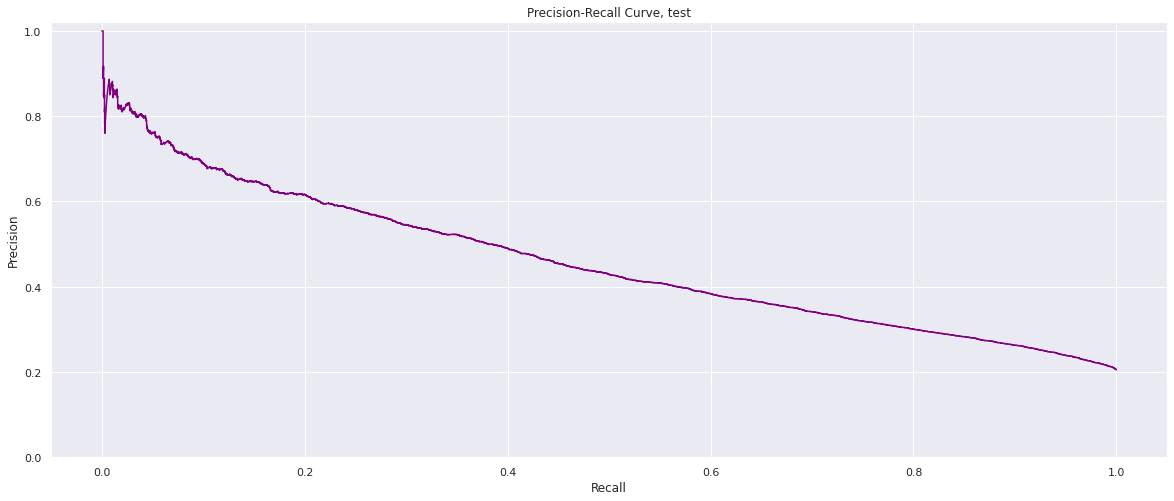

In [63]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-13 20:36:51,278] A new study created in memory with name: no-name-0aa1f23f-28ff-40ed-a068-3692749a3990
[I 2022-08-13 20:36:56,101] Trial 0 finished with value: 0.4673450902429932 and parameters: {'n_estimators': 640, 'max_depth': 3, 'learning_rate': 0.1372569685667385, 'colsample_bytree': 0.38746901935564093, 'subsample': 0.5523692556994813, 'alpha': 3.3299552137130486, 'lambda': 1.660701991876287, 'gamma': 0.0025914788880894556, 'min_child_weight': 0.3935961078268556}. Best is trial 0 with value: 0.4673450902429932.
[I 2022-08-13 20:37:02,811] Trial 1 finished with value: 0.4739873072455899 and parameters: {'n_estimators': 702, 'max_depth': 4, 'learning_rate': 0.06192075951270019, 'colsample_bytree': 0.11680360404271947, 'subsample': 0.9139508846785553, 'alpha': 8.854283149156146, 'lambda': 0.1180901376537117, 'gamma': 0.0022481050948247555, 'min_child_weight': 0.16669359978257203}. Best is trial 1 with value: 0.4739873072455899.
[I 2022-08-13 20:37:07,559] Trial 2 finished

Total time for hypermarameter optimization  194.1930365562439
        n_estimators : 807
           max_depth : 2
       learning_rate : 0.06620839798356493
    colsample_bytree : 0.9433322908545912
           subsample : 0.7237560569134655
               alpha : 0.14355179212605892
              lambda : 3.2310933468422283
               gamma : 3.0331942949891365e-08
    min_child_weight : 0.1730271532464366
best objective value : 0.47699455439660776


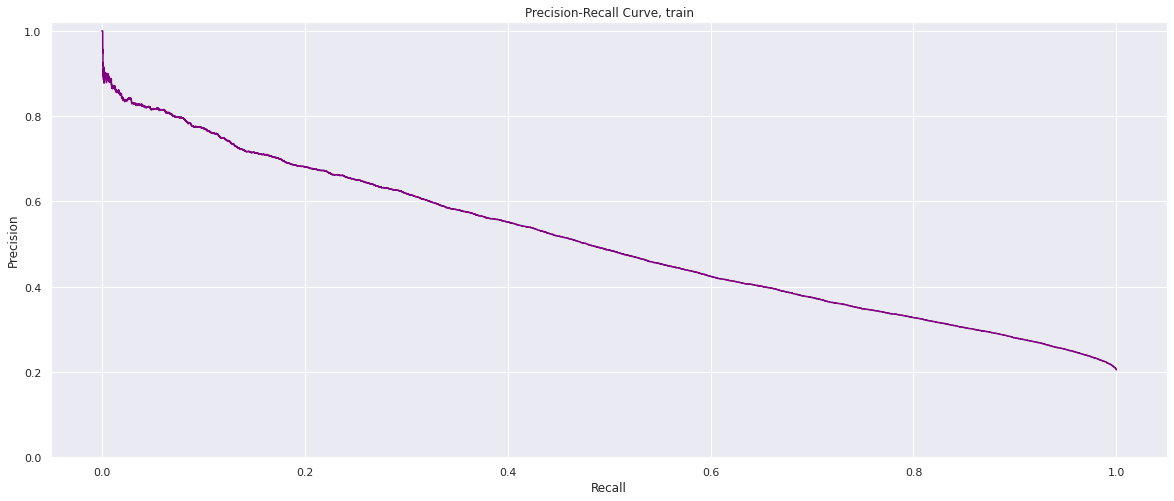

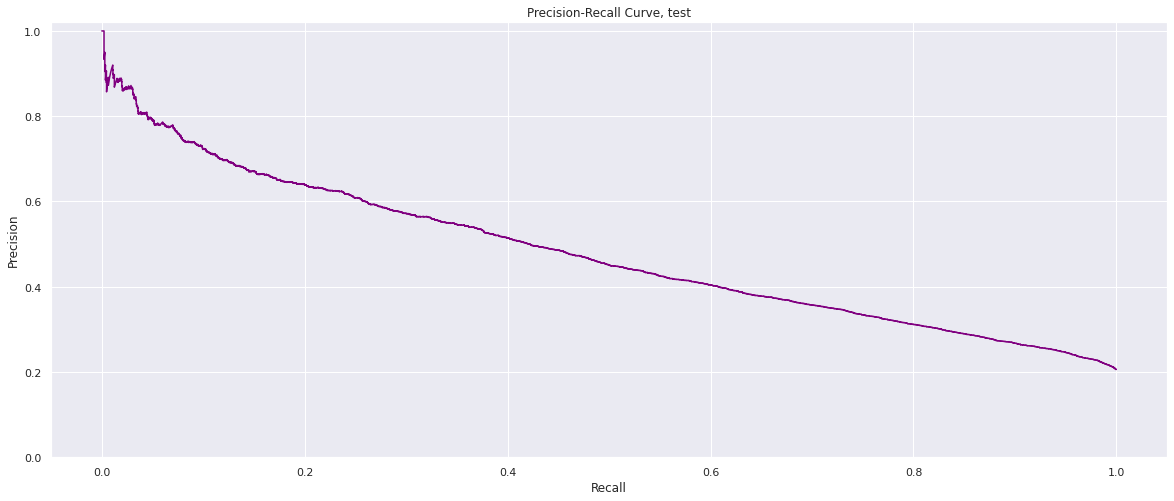

'Train Accuracy: '

0.8178868579138424

'F1 score: '

0.33822327717031797

'ROCAUC: '

0.5986325371244406

'PRAUC: '

0.5055591758196006

'R20P: '

0.6810589907604833

'Test Accuracy: '

0.8130039512994314

'F1 score: '

0.31702452188196645

'ROCAUC: '

0.5898949848349584

'PRAUC: '

0.4792760330150611

'R20P: '

0.6384039900249376

200.2824351787567

In [64]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.25),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

In [65]:
#results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
#fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
#fi = fi.sort_values('FI', ascending = False)

#display(fi)

,col_name,feature_importance_vals
71,remainder__sub_grade_encoded,0.326997
8,remainder__term,0.262284
26,remainder__acc_open_past_24mths,0.142335
54,remainder__year_issued,0.141394
59,remainder__lti,0.132053
14,remainder__dti,0.117947
78,remainder__home_ownership_encoded,0.113543
72,remainder__emp_title_encoded,0.113475
9,remainder__int_rate,0.110555
35,remainder__num_actv_rev_tl,0.102930


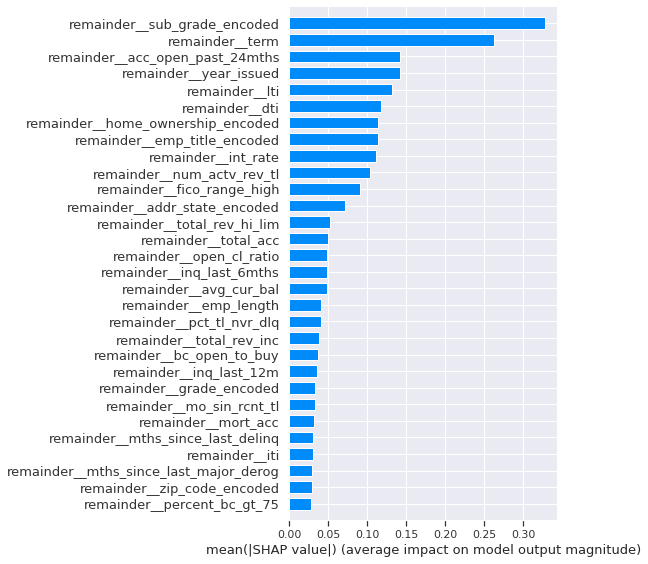

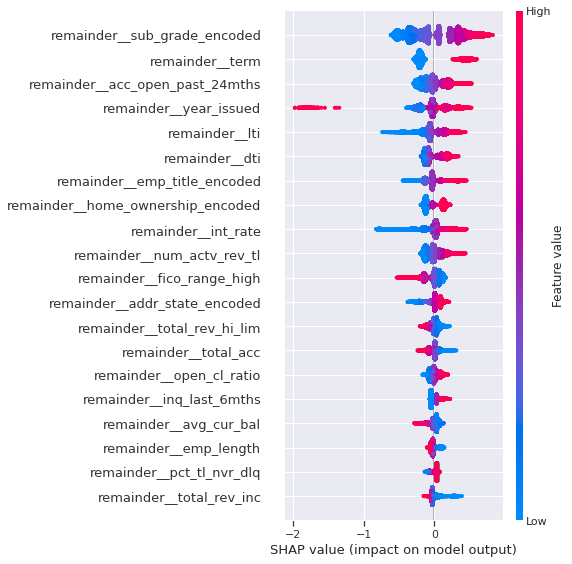

In [66]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [67]:
# error analysis
y_pred = optuna_xgb.predict_proba(X_test)[:, 1]
error_df = test00.copy()
error_df['truth'] = y_test
error_df['pred'] = y_pred
error_df['error'] = error_df.pred - error_df.truth
error_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error
0,13325.0,13325.0,13325.0,60.0,22.99,375.570007,debt_consolidation,Debt consolidation,w,Individual,F,F1,689.0,Teacher,3.0,RENT,47000.000000,381,TN,33.630001,Verified,2.0,14.0,14.0,1200.0,1200.0,1200.0,4.0,2.0,0.0,0.0,12.0,5.0,0.0,19.0,3736.0,44833.0,0.0,0.0,13300.0,13.0,0.0,3.0,13300.0,1.0,0.0,0.0,0.0,0.0,44833.0,0.0,0.0,0.000000,94.400002,0.0,0.0,1.0,0.0,0.0,1.0,2015.0,5,2015,5.579854,0.000000,1.0,0.283511,0.095890,0,0.000000,0.079489,0.953894,0.953894,0.282979,0,0.631579,0,1.0,0.798513,-0.201487
1,8000.0,8000.0,8000.0,36.0,12.49,267.600006,debt_consolidation,Debt consolidation,f,Individual,B,B5,699.0,sales,1.0,MORTGAGE,55000.000000,146,NY,8.160000,Not Verified,6.0,1200.0,1200.0,89.0,1200.0,1200.0,2.0,1.0,0.0,0.0,9.0,4.0,0.0,13.0,1192.0,10725.0,5535.0,31.3,6687.0,6.0,5.0,8.0,17700.0,0.0,0.0,0.0,1.0,1.0,10725.0,0.0,0.0,50.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,6,2014,10.165849,0.098369,0.0,0.145455,0.058385,0,0.100636,0.021673,0.195000,0.195000,0.321818,0,0.692308,1,0.0,0.151867,0.151867
2,25000.0,25000.0,25000.0,60.0,19.47,655.000000,credit_card,Credit card refinancing,f,Individual,D,D5,689.0,Call Taker,0.0,MORTGAGE,115000.000000,346,FL,14.870000,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,4.0,2.0,0.0,0.0,11.0,9.0,3.0,20.0,26297.0,289264.0,25558.0,86.1,1559.0,3.0,6.0,7.0,29700.0,0.0,0.0,0.0,0.0,0.0,51851.0,0.0,0.0,75.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,3,2014,16.999665,0.000000,0.0,0.217391,0.068348,0,0.222243,0.228670,2.515339,0.450878,0.258261,0,0.550000,0,0.0,0.314731,0.314731
3,4000.0,4000.0,4000.0,36.0,12.62,134.050003,debt_consolidation,Debt consolidation,w,Individual,C,C1,664.0,Technician,10.0,OWN,45000.000000,606,IL,11.520000,Source Verified,24.0,40.0,40.0,1200.0,40.0,40.0,0.0,1.0,0.0,1.0,5.0,1.0,0.0,14.0,2489.0,9955.0,1484.0,29.7,16.0,24.0,1.0,3.0,5000.0,0.0,0.0,0.0,0.0,0.0,9955.0,2444.0,0.0,100.000000,71.400002,0.0,0.0,0.0,0.0,0.0,2.0,2017.0,11,2017,11.167923,0.000000,0.0,0.088889,0.035747,0,0.032978,0.055311,0.221222,0.221222,0.111111,0,0.357143,0,0.0,0.163997,0.163997
4,8000.0,8000.0,8000.0,36.0,6.89,246.619995,credit_card,Credit card refinancing,w,Individual,A,A3,729.0,MISSING,0.0,OWN,75000.000000,917,CA,27.459999,Verified,2.0,40.0,40.0,1200.0,1200.0,40.0,6.0,1.0,0.0,0.0,22.0,10.0,5.0,65.0,7314.0,153585.0,9491.0,8.3,55246.0,2.0,6.0,20.0,113800.0,0.0,0.0,0.0,0.0,0.0,153585.0,0.0,0.0,0.000000,96.900002,0.0,0.0,0.0,0.0,0.0,2.0,2015.0,6,2015,32.917856,0.000000,0.0,0.106667,0.039459,0,0.126547,0.097520,2.047800,2.047800,1.517333,0,0.338462,0,0.0,0.078906,0.078906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31124,10000.0,10000.0,10000.0,60.0,12.40,224

In [68]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error>0.8])

,truth,pred
count,31129.000000,31129.000000
mean,0.205146,0.205931
std,0.403815,0.158955
min,0.000000,0.002334
25%,0.000000,0.090403
50%,0.000000,0.159793
75%,0.000000,0.273721
max,1.000000,0.916251


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error
2443,20000.0,20000.0,20000.0,60.0,26.30,602.369995,debt_consolidation,Debt consolidation,w,Individual,E,E5,669.0,RN,10.0,RENT,54000.0,190,PA,30.469999,Source Verified,4.0,20.0,78.0,76.0,1200.0,20.0,3.0,0.0,0.0,1.0,16.0,7.0,0.0,26.0,2213.0,35409.0,17745.0,49.7,10173.0,4.0,9.0,12.0,35700.0,1.0,0.0,0.0,1.0,1.0,35409.0,0.0,0.0,25.000000,87.500000,3.0,0.0,0.0,0.0,0.0,0.0,2017.0,11,2017,12.504021,0.079974,0.0,0.370370,0.133860,0,0.328611,0.040981,0.655722,0.655722,0.661111,0,0.615385,1,0.0,0.804941,0.804941
3282,16200.0,16200.0,16200.0,60.0,20.99,438.179993,debt_consolidation,Debt consolidation,w,Individual,E,E5,669.0,Service clerk,10.0,RENT,45000.0,917,CA,23.469999,Verified,3.0,1200.0,1200.0,82.0,1200.0,1200.0,1.0,1.0,0.0,0.0,29.0,14.0,0.0,36.0,828.0,23177.0,18359.0,48.2,8234.0,3.0,20.0,27.0,38100.0,0.0,0.0,0.0,1.0,0.0,23177.0,0.0,0.0,53.299999,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,8,2015,15.165267,0.065940,0.0,0.360000,0.116848,0,0.407978,0.018400,0.515044,0.515044,0.846667,0,0.805556,0,0.0,0.845380,0.845380
14789,10800.0,10800.0,10800.0,60.0,28.72,340.980011,major_purchase,Major purchase,w,Joint App,F,F1,699.0,Server,0.0,RENT,14000.0,313,GA,28.219999,Source Verified,12.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,5.0,3.0,10.0,8.0,0.0,16.0,1103.0,11033.0,2982.0,54.2,1200.0,12.0,4.0,9.0,5500.0,0.0,0.0,0.0,0.0,0.0,11033.0,0.0,0.0,50.000000,100.000000,2.0,0.0,0.0,0.0,0.0,0.0,2017.0,11,2017,7.419728,0.000000,0.0,0.771429,0.292269,1,0.213000,0.078786,0.788071,0.788071,0.392857,0,0.625000,0,0.0,0.858969,0.858969
15170,16000.0,16000.0,16000.0,60.0,18.94,414.529999,debt_consolidation,Debt consolidation,w,Individual,D,D2,729.0,MISSING,0.0,RENT,31000.0,891,NV,29.580000,Not Verified,7.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,3.0,19.0,18.0,0.0,26.0,1893.0,35975.0,20894.0,21.0,78606.0,7.0,8.0,15.0,99500.0,0.0,0.0,0.0,0.0,0.0,35975.0,0.0,0.0,13.300000,100.000000,3.0,0.0,0.0,0.0,0.0,0.0,2018.0,10,2018,4.251970,0.000000,0.0,0.516129,0.160463,0,0.674000,0.061065,1.160484,1.160484,3.209677,0,0.730769,0,0.0,0.812273,0.812273
15911,14525.0,14525.0,14525.0,60.0,19.19,378.309998,debt_consolidation,Debt consolidation,f,Individual,E,E3,714.0,CSR,8.0,RENT,34000.0,787,TX,30.000000,Verified,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,4.0,2.0,0.0,0.0,18.0,11.0,0.0,22.0,1683.0,30288.0,2129.0,10.1,7136.0,8.0,8.0,15.0,21100.0,0.0,0.0,0.0,0.0,0.0,30288.0,66.0,0.0,11.100000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,7,2015,6.661328,0.000000,0.0,0.427206,0.133521,0,0.062618,0.049500,0.890824,0.890824,0.620588,0,0.818182,0,0.0,0.814068,0.814068
16982,30000.0,30000.0,30000.0,60.0,28.72,947.150024,house,Home buying,w,Individual,F,F1,684.0,recruiter,3.0,MORTGAGE,89000.0,480,MI,0.000000,Source Verified,34.0,1200.0,1200.0,95.0,1200.0,1200.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,500.0,34.0,0.0,1.0,500.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,13.

In [69]:
error_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,fico_range_high,emp_length,annual_inc,zip_code,dti,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error
count,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,3.112900e+04,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,30327.000000,31129.000000,31129.000000,29958.000000,2.995800e+04,3.112900e+04,31129.000000,30025.000000,29958.000000,29958.000000,29958.000000,2.995800e+04,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,3.032700e+04,29958.000000,31128.000000,30016.000000,29956.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,29958.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,29958.000000,29958.000000,30327.000000,29958.000000,31129.0,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000
mean,14589.414062,14582.731445,14567.282227,41.567285,12.905904,441.333618,701.933777,5.594494,7.821509e+04,513.503196,18.292601,12.416846,625.270813,900.394104,1016.242065,925.920288,813.758484,2.020495,0.600276,0.566481,1.143949,11.555784,4.570647,1.619519,24.589418,14006.701172,1.462520e+05,1.667460e+04,50.786806,11117.365234,13.832432,5.535650,8.178583,3.431816e+04,0.318995,0.004819,9.677471,0.205146,0.130907,5.106011e+04,238.457413,0.049280,43.284729,94.107780,0.710013,0.388641,0.084262,0.003469,0.000353,0.514253,2015.543448,6.498795,2015.543448,16.410080,0.013669,0.205146,0.214551,0.079323,0.036172,8.095242,8.202993,69.505173,23.557703,17.039553,0.0,0.508435,0.121366,0.205146,0.205931,0.000785
std,9022.372070,9018.393555,9017.072266,10.130324,4.673802,268.550262,32.685116,3.865304,6.447292e+04,311.842094,9.249302,23.076122,582.991333,506.741089,416.597839,493.155701,548.418579,1.831582,0.894370,1.226431,2.056357,5.528678,3.132652,1.932586,11.926024,16976.933594,1.648786e+05,2.497070e+04,24.698838,16581.302734,17.256514,3.287695,4.590682,3.680477e+04,0.884712,0.075039,517.117249,0.570520,0.374150,5.150655e+04,2180.551270,0.369179,36.145119,8.961126,1.287397,0.790513,0.494443,0.063528,0.018795,1.359889,1.838992,3.426244,1.838992,7.595068,0.040950,0.403815,0.134655,0.055525,0.186721,495.500061,515.379639,4179.439941,1264.735107,871.471802,0.0,0.178090,0.326557,0.403815,0.158955,0.369991
min,1000.000000,1000.000000,0.000000,36.000000,5.310000,19.400000,664.000000,0.000000,1.000000e+00,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,16.700001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,1.000000,2007.000000,2.998008,0.000000,0.000000,0.000639,0.000241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.055556,0.000000,0.000000,0.002334,-0.985669
25%,7700.000000,7700.000000,7625.000000,36.000000,

In [70]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error<-0.95])

,truth,pred
count,31129.000000,31129.000000
mean,0.205146,0.205931
std,0.403815,0.158955
min,0.000000,0.002334
25%,0.000000,0.090403
50%,0.000000,0.159793
75%,0.000000,0.273721
max,1.000000,0.916251


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error
272,21400.0,21400.0,21400.0,36.0,6.03,651.330017,debt_consolidation,Debt consolidation,f,Individual,A,A1,759.0,Owner,8.0,MORTGAGE,125000.0,383,TN,9.110000,Source Verified,6.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,11.0,13.0,15.0,64.0,11415.0,114154.0,21419.0,40.3,18581.0,10.0,2.0,8.0,53100.0,0.0,0.0,0.0,0.0,0.0,54398.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,8,2014,10.833898,0.000000,1.0,0.171200,0.062528,0,0.171352,0.091320,0.913232,0.435184,0.424800,0,0.171875,0,1.0,0.037178,-0.962822
775,10000.0,10000.0,10000.0,36.0,5.32,301.149994,debt_consolidation,Debt consolidation,w,Individual,A,A1,714.0,Associate Project Manager,1.0,MORTGAGE,120000.0,300,GA,20.700001,Source Verified,9.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,1.0,1.0,7.0,3.0,1.0,19.0,34669.0,242684.0,8481.0,64.3,119.0,42.0,1.0,2.0,13200.0,0.0,0.0,0.0,0.0,0.0,59684.0,0.0,0.0,100.000000,100.000000,0.0,1.0,0.0,0.0,0.0,0.0,2016.0,12,2016,14.831242,0.000000,1.0,0.083333,0.030115,0,0.070675,0.288908,2.022367,0.497367,0.110000,0,0.368421,0,1.0,0.031707,-0.968293
948,35000.0,35000.0,35000.0,36.0,10.49,1137.430054,debt_consolidation,Debt consolidation,w,Individual,B,B2,674.0,VP of IT,3.0,MORTGAGE,135000.0,800,CO,20.280001,Verified,16.0,0.0,1200.0,1200.0,38.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,2.0,22.0,17806.0,124641.0,84133.0,20.5,31158.0,16.0,3.0,4.0,124200.0,1.0,1.0,0.0,0.0,0.0,124641.0,0.0,0.0,0.000000,85.699997,0.0,0.0,0.0,1.0,0.0,0.0,2016.0,12,2016,22.001821,0.000000,1.0,0.259259,0.101105,0,0.623207,0.131896,0.923267,0.923267,0.920000,0,0.318182,0,1.0,0.046672,-0.953328
1351,8000.0,8000.0,8000.0,36.0,5.32,240.919998,car,Car financing,w,Individual,A,A1,774.0,Owner/ veterinarian,3.0,MORTGAGE,110000.0,711,LA,26.000000,Source Verified,1.0,71.0,1200.0,1200.0,71.0,71.0,1.0,1.0,3.0,2.0,15.0,5.0,2.0,37.0,18883.0,264363.0,7579.0,16.4,19100.0,1.0,3.0,10.0,46100.0,0.0,0.0,0.0,0.0,0.0,93865.0,0.0,0.0,0.000000,97.300003,1.0,0.0,0.0,0.0,0.0,0.0,2017.0,8,2017,16.419228,0.000000,1.0,0.072727,0.026282,0,0.068900,0.171664,2.403300,0.853318,0.419091,0,0.405405,0,1.0,0.026087,-0.973913
2006,15000.0,15000.0,15000.0,36.0,9.17,478.190002,home_improvement,Home improvement,f,Individual,B,B1,694.0,Teacher,10.0,MORTGAGE,75000.0,606,IL,20.750000,Not Verified,5.0,60.0,60.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,13.0,2.0,4.0,32.0,12622.0,164085.0,32723.0,71.6,10953.0,5.0,7.0,8.0,45700.0,0.0,0.0,0.0,0.0,0.0,71989.0,0.0,0.0,20.000000,96.800003,0.0,0.0,0.0,0.0,0.0,1.0,2014.0,7,2014,19.830660,0.000000,1.0,0.200000,0.076510,0,0.436307,0.168293,2.187800,0.959853,0.609333,0,0.406250,0,1.0,0.032495,-0.967505
2107,8500.0,8500.0,8500.0,36.0,9.17,270.980011,home_improvement,Home improvement,f,Individual,B,B2,704.0,firefighter,10.0,MORTGAGE,93000.0,23,MA,8.610000,Not Verified,2.0,8.0,13.0,1200.0,8.0,8.0,3.0,1.0,0.0,0.0,10.0,3.0,4.0,27.0,24201.0,242012.0,2346.0,8.8,19000.0,3.0,3.0,8.0,26700.0,2.0,0.0,0.0,0.0,0.0,22070.0,0.0,0.0,0

In [71]:
#indx = 9506
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

In [72]:
#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [73]:
error_df[['pred','truth']].describe()

,pred,truth
count,31129.000000,31129.000000
mean,0.205931,0.205146
std,0.158955,0.403815
min,0.002334,0.000000
25%,0.090403,0.000000
50%,0.159793,0.000000
75%,0.273721,0.000000
max,0.916251,1.000000


In [74]:
display(error_df.groupby('year_issued').error.mean())
display(error_df.groupby('term').error.mean())
display(error_df.groupby('grade').error.mean())
display(error_df.groupby('purpose').error.mean())


year_issued
2007.0    0.119467
2008.0    0.020087
2009.0   -0.005290
2010.0    0.012686
2011.0    0.009391
2012.0    0.008546
2013.0    0.019454
2014.0   -0.004314
2015.0    0.000604
2016.0   -0.005122
2017.0   -0.003819
2018.0    0.004167
2019.0    0.012722
2020.0    0.002423
Name: error, dtype: float64

term
36.0    0.000987
60.0    0.000117
Name: error, dtype: float64

grade
A    0.005941
B   -0.000082
C   -0.004535
D    0.006787
E    0.005744
F   -0.000358
G   -0.047141
Name: error, dtype: float64

purpose
car                   0.014727
credit_card           0.003794
debt_consolidation   -0.000403
home_improvement     -0.010274
house                 0.006978
major_purchase        0.009109
medical              -0.021295
moving               -0.030919
other                 0.002095
small_business        0.055295
vacation              0.024059
Name: error, dtype: float64

In [75]:
time.time()-time0

269.05722999572754

### 8. Business implications